# Amazon Product Review Analysis
**Problem Statement**
 
In -This ProjectI am analyzing  og Amazon'sextensivet customer reviews touncover meaningful insights about product quality, price, and shipping. By leveraging with sentiment analysis and aspect-based analysis (ABSA), I aim to identify customer feedback trends and pinpoint area for improvement.

The goal is to help Amazon and its sellers make informed decision by addressing specific customer pain pints, enhancing popular product features, and providing targeted recommendations. This will ultimately contributr to improved customer satisfaction and loyality, creating a better shopping experience for all.

- **Dataset**  
This Dataset is of customer reviews from the "Cell phones & Accessories" category and stored as a JSON file.The dataset can be accessed on Kaggle:
  - [Amazon Reviews Dataset on Kaggle](https://www.kaggle.com/datasets/abdallahwagih/amazon-reviews/code)



## **System Design and Methodology**

The NLP pipeline includes the following components:

1. **Data Ingestion:**  
   - Loading and exploring the dataset to understand its structure, shape, and overall quality.  

2. **Data Preprocessing:**  
   - Cleaning the text data by removing noise (e.g., special characters, HTML tags).  
   - Tokenize and lemmatize words to standardize text.  
   - Handle stop words to focus on meaningful terms relevant to analysis.  

3. **Feature Extraction:**  
   - Converting textual data into numerical representations using **TF-IDF vectorization**.

4. **Model Training:**  
   - Training Machine learning model like **Logistic Regression** for sentiment analysis.  
   - Implemented **Aspect-Based Sentiment Analysis (ABSA)** to categorize reviews by specific aspects (e.g., quality, price, shipping).  

5. **Evaluation:**  
   - Evaluating the performance of the models using metrics such as accuracy, precision, recall, and F1-score to ensure robust analysis.  

6. **Visualization & Insights:**  
   - Using charts and word clouds to present findings and summarize trends:  
     - **Heatmaps:** Display aspect-sentiment distributions, highlighting how sentiments vary across aspects like quality, price, and shipping.  
     - **Bar Charts:** Illustrate the frequency of sentiments for each aspect, offering a clear comparative view.  
     - **Word Clouds:** Summarize common themes within aspects by visualizing the most frequent terms associated with specific sentiments (e.g., positive, negative, neutral).  .

    +----------------+      +----------------+      +--------------------+
    |  Data Ingestion| ---> |Data Preprocessing|---> | Feature Extraction |
    +----------------+      +----------------+      +--------------------+
                                                         |
                                                         v
                                               +--------------------+
                                               |      Modeling      |
                                               +--------------------+
                                                         |
                                                         v
                                               +--------------------+
                                               |     Evaluation     |
                                               +--------------------+
                                                         |
                                                         v
                                               +--------------------+
                                               |Insights & Reporting|
                                               +--------------------+


In [9]:
#importing Libraries
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

I did Sampling and took 10% of Actual as the **original dataset** contains **194,439** rows and 9 columns, making it computationally expensive to process.Sampling 10% of the data reduces the size to 19,444 rows while still preserving the dataset's structure and diversity, allowing for quicker experimentation and iteration without significant loss of insights

In [12]:
#loading the dataset
file_path = "amazon_reviews/Cell_Phones_and_Accessories_5.json"
data = pd.read_json(file_path, lines=True)

# Taking 10% sample of the dataset as this is very large dataset 
Sample_data = data.sample(frac=0.10, random_state=42)
print(Sample_data.info())
print(Sample_data.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
Index: 19444 entries, 156187 to 120715
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      19444 non-null  object
 1   asin            19444 non-null  object
 2   reviewerName    19070 non-null  object
 3   helpful         19444 non-null  object
 4   reviewText      19444 non-null  object
 5   overall         19444 non-null  int64 
 6   summary         19444 non-null  object
 7   unixReviewTime  19444 non-null  int64 
 8   reviewTime      19444 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.5+ MB
None
            reviewerID        asin     reviewerName helpful reviewText  \
count            19444       19444            19070   19444      19444   
unique           13736        6875            12292     355      19432   
top     A1UQBFCERIP7VJ  B005SUHPO6  Amazon Customer  [0, 0]              
freq                16          82              364   14

In [16]:
#Exploring the Data 
Sample_data.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
156187,A1P3ACSVXZ1JUM,B00C0ZKI9Q,LO127,"[0, 0]",iBOLT xProDock Active Car Dock/Holder/Mount fo...,5,Fits perfectly,1372032000,"06 24, 2013"
102252,A2Z3IZDQUIDRR9,B008FQVO5G,yogitim,"[8, 8]",This pouch is everything that I was looking fo...,5,Great Pouch!,1361577600,"02 23, 2013"
23146,A3EOVXI1VZIHUQ,B003Y74AZ2,"Z. Freeman ""Zach""","[1, 2]",First of all - the case I had on my iPhone 4 p...,3,An average iPhone case - nothing fancy,1296604800,"02 2, 2011"


### Data Preprocessing

In [21]:
#Here i am chekcing Missing value and will drop in next step if its not required for my analysis
Sample_data.isnull().sum()

reviewerID          0
asin                0
reviewerName      374
helpful             0
reviewText          0
overall             0
summary             0
unixReviewTime      0
reviewTime          0
dtype: int64

**Dropping irrelevant Column**

In [23]:
# Dropping unnecessary columns here 
Sample_data = Sample_data.drop(columns=['reviewerID', 'asin', 'reviewerName', 'unixReviewTime', 'reviewTime'], errors='ignore')
# Concatenate 'summary' with 'reviewText' for better analysis
Sample_data['full_review'] = Sample_data['summary'] + ' ' + Sample_data['reviewText']

In [25]:
# After addressing Missing value and dropping irelvant columns let me check for overall count of ratings
Sample_data['overall'].value_counts()

overall
5    10850
4     4052
3     2087
1     1336
2     1119
Name: count, dtype: int64

Now i will do the mapping which is a preprocessing step required to define the target variable (sentiment) for sentiment classification tasks. This mapping simplifies the target variable, aligns the dataset with sentiment analysis goals, and provides actionable insights into the distribution of customer sentiment, guiding preprocessing and modeling decisions.'

In [27]:
# No i Mapped the 'overall' ratings to sentiment labels
def map_overall_to_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating >= 3:
        return 'neutral'
    else:
        return 'negative'
# Apply the mapping function to create a 'sentiment' column
Sample_data['sentiment'] = Sample_data['overall'].apply(map_overall_to_sentiment)

# Display the sentiment distribution
Sample_data['sentiment'].value_counts()

sentiment
positive    14902
negative     2455
neutral      2087
Name: count, dtype: int64

This Mapping rating simplifies the problem into a multi-class classification.

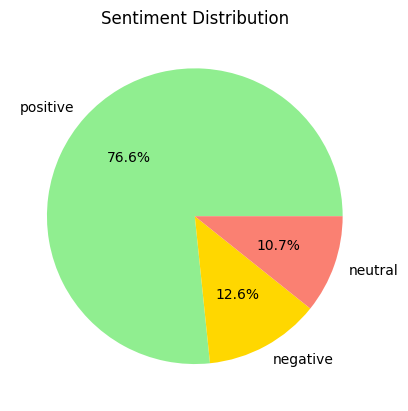

In [33]:
#visualizing the data with pie chart
sentiment_counts=Sample_data['sentiment'].value_counts()
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'gold', 'salmon'])
plt.title('Sentiment Distribution')
plt.ylabel('')  # Removing the y-axis label for a cleaner look
plt.show()

### Interpretation of Sentiment Distribution:

From this graph its clearly visible that the dataset is imbalanced and we need to balance this befor splitting the data and after complete preprocessing


## Data Preprocessing

This section involves cleaning and preparing the text dataClean the review text to make it easier to analyze. . We perform several steps:
1. **Tokenization**: Splitting sentences into individual words.
2. **Stop Words Removal**: Removing common words that do not carry significant meaning (e.g., 'the', 'is').
3. **Stemming/Lemmatization**: Reducing words to their base.
4. **Negations**rn').


In [42]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Define simplified preprocessing function
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters but keep spaces and numbers
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Tokenize and handle negations in one step
    tokens = word_tokenize(text)
    negation_map = {"dont": "do not", "didnt": "did not", "cant": "can not", "couldnt": "could not", "wont": "will not"}
    processed_tokens = []
    for i, word in enumerate(tokens):
        # Expand negations
        if word in negation_map:
            processed_tokens.extend(negation_map[word].split())
        # Handle "not" by attaching it to the next word
        elif word == "not" and i + 1 < len(tokens):
            processed_tokens.append(f"not_{tokens[i + 1]}")
        # Skip the word after "not" (already attached as "not_<word>")
        elif i > 0 and tokens[i - 1] == "not":
            continue
        # Otherwise, keep the word
        else:
            processed_tokens.append(word)
    # Remove stopwords and lemmatize
    processed_tokens = [
        lemmatizer.lemmatize(word) for word in processed_tokens if word not in stop_words
    ]
    return ' '.join(processed_tokens)

# Apply the simplified preprocessing function to 'full_review'
Sample_data['processed_review'] = Sample_data['full_review'].apply(
    lambda x: preprocess_text(x) if pd.notnull(x) else ''
)

# Display a sample of the DataFrame to check the result
Sample_data[['full_review', 'processed_review']].head(10)

,full_review,processed_review
156187,Fits perfectly iBOLT xProDock Active Car Dock/...,fit perfectly ibolt xprodock active car dockho...
102252,Great Pouch! This pouch is everything that I w...,great pouch pouch everything looking otter box...
23146,An average iPhone case - nothing fancy First o...,average iphone case nothing fancy first case i...
86461,Great Case I ordered this case because I had t...,great case ordered case case htc inspire case ...
62407,Cute Bought a few of these as gifts. They were...,cute bought gift big hit loved choice color ma...
53327,Make great pictures This is a must have for an...,make great picture must wan na photographer lo...
109587,Adapter thanks. I think this is the best chois...,adapter thanks think best choise see otg adapt...
44009,"Love it Works great and at a great price, I lo...",love work great great price love apple wait up...
68194,"Fits well, works well. Fits well on the Atrix ...",fit well work well fit well atrix 2 atrix 2 co...
13013,great product Long cable permits charging your...,great product long cable permit charging devic...


- **`Preprocess_text` function**:
  - Converts each review to lowercase.
  - Removing HTML Tags.
  - Removing Special Characters and Numbers
  - Removes stop words and lemmatizes each word.
  - Handling Negations,

- Now, I will do the aspect identification which breakdown reviews into specific Category of qualit, shipping and price as my problem is sentiment analysis based on aspect identification it is because When sentiments are linked to specific aspects identified in the text, Sentiment classification works best

In [58]:
from collections import Counter

# Combine all processed reviews into a single string
all_words = ' '.join(Sample_data['processed_review'])

# Count the most common words
word_counts = Counter(all_words.split()).most_common(20)

# Print the most common words
word_counts

[('phone', 19844),
 ('case', 18573),
 ('one', 9885),
 ('great', 9767),
 ('like', 7771),
 ('good', 7539),
 ('work', 7092),
 ('battery', 6987),
 ('screen', 6707),
 ('use', 6417),
 ('would', 5545),
 ('well', 5544),
 ('charge', 5438),
 ('get', 5369),
 ('charger', 5240),
 ('product', 5195),
 ('iphone', 5184),
 ('fit', 5171),
 ('time', 4833),
 ('device', 4332)]

## Aspect Identification

Here i will use mixed approach the rule based and spacy based aspect identification

In [75]:
# Importing spaCy for aspect identification
import spacy

# Loading spaCy's English language model
nlp = spacy.load("en_core_web_sm")

# Define the aspect keywords for filtering
aspect_keywords = {
    'quality': ['well', 'quality', 'durable', 'build', 'love', 'cute', 'material', 'sturdy', 'strong', 'good', 'great', 'excellent', 'fine', 'awesome', 'solid', 'perfect', 'well-made'],
    'price': ['price', 'cost', 'expensive', 'cheap', 'affordable', 'value', 'reasonable', 'overpriced', 'worth', 'deal', 'budget', 'pricy', 'pricing', 'money', 'pay', 'investment', 'economical', 'worth it'],
    'shipping': ['time', 'shipping', 'delivery', 'arrival', 'package', 'ship', 'deliver', 'fast', 'slow', 'timely', 'delayed', 'on time', 'late', 'quick', 'dispatch', 'sent', 'courier', 'transit', 'shipment'],
    'functionality': ['case', 'device', 'charger', 'broke', 'port', 'charge', 'charging', 'usb', 'vehicle', 'cable', 'adapter', 'plug', 'connect', 'use', 'function', 'work', 'feature', 'button', 'response', 'operate', 'control', 'performance']
}

# Identifying aspects using spaCy
def identify_aspects_spacy(review):
    doc = nlp(review)
    aspects = []
    for token in doc:
        # Identifying noun phrases or nouns with adjective modifiers
        if token.pos_ == "NOUN":
            # Checking if the noun has an adjective modifier
            modifiers = [child.text for child in token.children if child.pos_ == "ADJ"]
            if modifiers:
                aspects.append((token.text, modifiers))  # Capturing noun and its modifiers
            else:
                aspects.append((token.text, []))  # Capturing noun without modifiers
    return aspects

# Applying spaCy-based aspect identification
Sample_data['aspects_spacy'] = Sample_data['processed_review'].apply(identify_aspects_spacy)

# Filtering spaCy aspects based on predefined keywords
def filter_spacy_aspects(aspects_spacy, keywords):
    filtered_aspects = []
    for noun, modifiers in aspects_spacy:
        for category, category_keywords in keywords.items():
            if noun in category_keywords:  # Checking if the noun matches any keyword in predefined categories
                filtered_aspects.append((category, noun, modifiers))
                break  # Stop after finding the first match for a category
    return filtered_aspects

# Filtering spaCy aspects using aspect_keywords
Sample_data['filtered_aspects'] = Sample_data['aspects_spacy'].apply(
    lambda aspects: filter_spacy_aspects(aspects, aspect_keywords)
)

# Adding rule-based aspects to cover missed keywords
def add_rule_based_aspects(review, aspects_spacy, keywords):
    rule_based_aspects = []
    # Extracting identified nouns from spaCy results
    identified_nouns = {noun for _, noun, _ in aspects_spacy}
    for aspect, category_keywords in keywords.items():
        for keyword in category_keywords:
            if keyword in review and keyword not in identified_nouns:  # Adding if spaCy missed it
                rule_based_aspects.append(aspect)
                break  # Stop after finding the first match for an aspect
    return rule_based_aspects

# Combining spaCy and rule-based aspects
def combine_aspects(review, aspects_spacy, keywords):
    spacy_aspects = filter_spacy_aspects(aspects_spacy, keywords)
    rule_based_aspects = add_rule_based_aspects(review, spacy_aspects, keywords)
    # Combining spaCy and rule-based aspects, avoiding duplicates
    combined_aspects = {aspect for aspect, _, _ in spacy_aspects} | set(rule_based_aspects)
    return list(combined_aspects)

# Applying the combined approach
Sample_data['final_aspects'] = Sample_data.apply(
    lambda row: combine_aspects(row['processed_review'], row['aspects_spacy'], aspect_keywords),
    axis=1
)

In [138]:
Sample_data[['processed_review', 'final_aspects']].head(10)

,processed_review,final_aspects
0,fit perfectly ibolt xprodock active car dockho...,"[functionality, quality]"
1,great pouch pouch everything looking otter box...,"[price, functionality, quality]"
2,average iphone case nothing fancy first case i...,"[functionality, quality]"
3,great case ordered case case htc inspire case ...,"[price, functionality, quality]"
4,cute bought gift big hit loved choice color ma...,"[price, functionality, quality]"
5,make great picture must wan na photographer lo...,[quality]
6,adapter thanks think best choise see otg adapt...,[functionality]
7,love work great great price love apple wait up...,"[price, functionality, quality]"
8,fit well work well fit well atrix 2 atrix 2 co...,"[price, functionality, quality]"
9,great product long cable permit charging devic...,"[functionality, quality]"


It looks better now will compute sentimnets for aspects and detrmine the polarity of sentiments.

In [140]:
from textblob import TextBlob

# Compute sentiment for aspects
def analyze_aspect_sentiment(aspects, review):
    aspect_sentiments = {}
    for aspect in aspects:
        # Compute sentiment polarity for the full review
        sentiment = TextBlob(review).sentiment.polarity
        aspect_sentiments[aspect] = sentiment
    return aspect_sentiments

# Apply aspect sentiment analysis
Sample_data['aspect_sentiments'] = Sample_data.apply(
    lambda row: analyze_aspect_sentiment(row['final_aspects'], row['processed_review']),
    axis=1
)

# Inspect results
Sample_data[['final_aspects', 'aspect_sentiments']].head()

,final_aspects,aspect_sentiments
0,"[functionality, quality]","{'functionality': 0.5296296296296297, 'quality..."
1,"[price, functionality, quality]","{'price': 0.5833333333333334, 'functionality':..."
2,"[functionality, quality]","{'functionality': -0.039214046822742474, 'qual..."
3,"[price, functionality, quality]","{'price': 0.5, 'functionality': 0.5, 'quality'..."
4,"[price, functionality, quality]","{'price': 0.4083333333333333, 'functionality':..."


In [154]:
# Map review polarity into categorical sentiments
def map_sentiment(score):
    if score > 0.1:  # Positive threshold
        return "positive"
    elif score < -0.1:  # Negative threshold
        return "negative"
    else:  # Neutral range
        return "neutral"

# Compute sentiment polarity for the entire review
Sample_data['sentiment'] = Sample_data['processed_review'].apply(
    lambda x: TextBlob(x).sentiment.polarity
)

# Map sentiment polarity to overall sentiment categories
Sample_data['overall_sentiment'] = Sample_data['sentiment'].apply(map_sentiment)

# Inspect the overall sentiment distribution
print(Sample_data['overall_sentiment'].value_counts())

overall_sentiment
positive    16076
neutral      2701
negative      667
Name: count, dtype: int64


In [156]:
# Extract aspect sentiment scores into a DataFrame
aspect_sentiments_df = pd.DataFrame(list(Sample_data['aspect_sentiments'])).fillna(0)

# Compute average sentiment for each aspect
avg_sentiment = aspect_sentiments_df.mean()

# Display average sentiment
print(avg_sentiment)

functionality    0.230599
quality          0.266241
price            0.096092
shipping         0.081812
dtype: float64


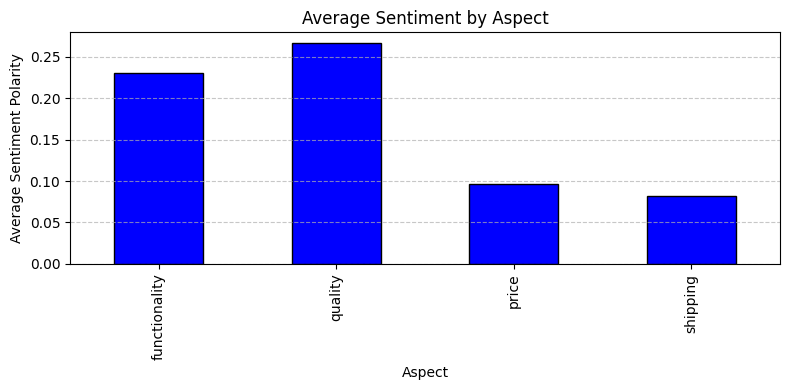

In [158]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
avg_sentiment.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Average Sentiment by Aspect', fontsize=12)
plt.xlabel('Aspect', fontsize=10)
plt.ylabel('Average Sentiment Polarity', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

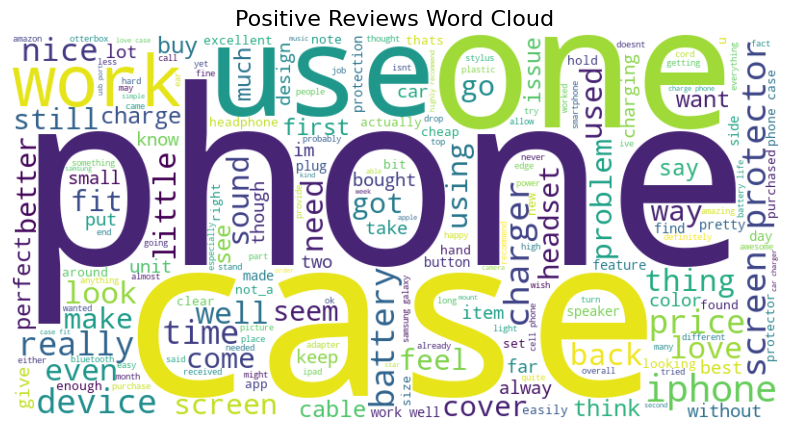

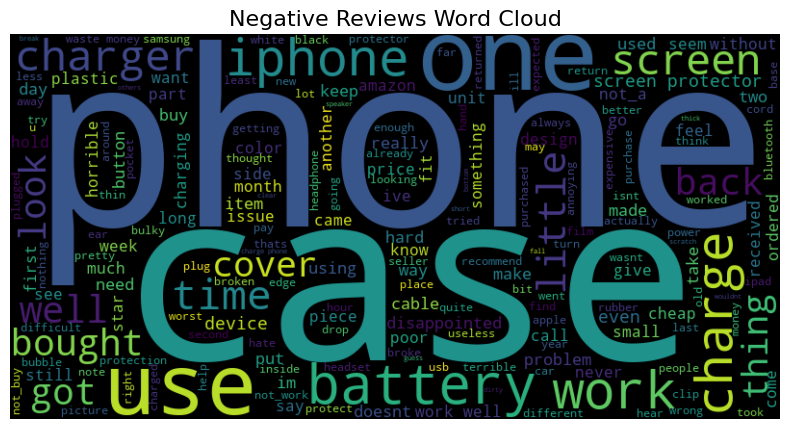

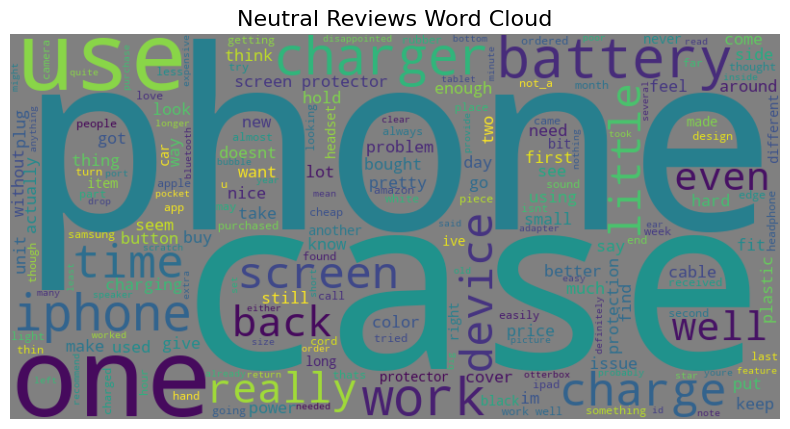

In [148]:
# Import required libraries
from wordcloud import WordCloud
from textblob import TextBlob
import matplotlib.pyplot as plt

# Add sentiment polarity to the dataset
Sample_data['sentiment'] = Sample_data['processed_review'].apply(
    lambda x: TextBlob(x).sentiment.polarity
)

# Separate reviews based on sentiment polarity
positive_reviews = ' '.join(Sample_data[Sample_data['sentiment'] > 0]['processed_review'])
negative_reviews = ' '.join(Sample_data[Sample_data['sentiment'] < 0]['processed_review'])
neutral_reviews = ' '.join(Sample_data[(Sample_data['sentiment'] >= -0.1) & (Sample_data['sentiment'] <= 0.1)]['processed_review'])

# Define custom stopwords (optional)
custom_stopwords = set(WordCloud().stopwords) | {'good', 'bad', 'great', 'like', 'product', 'review', 'quality'}

# Generate word clouds
positive_wordcloud = WordCloud(
    width=800, height=400, background_color='white', stopwords=custom_stopwords
).generate(positive_reviews)

negative_wordcloud = WordCloud(
    width=800, height=400, background_color='black', stopwords=custom_stopwords
).generate(negative_reviews)

neutral_wordcloud = WordCloud(
    width=800, height=400, background_color='gray', stopwords=custom_stopwords
).generate(neutral_reviews)

# Plot word clouds
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews Word Cloud", fontsize=16)
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Reviews Word Cloud", fontsize=16)
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Neutral Reviews Word Cloud", fontsize=16)
plt.show()

### Feature Engineering

### TF-IDF Feature Extraction

We will use **TF-IDF Vectorizer** to convert the text data into numerical features, making it ready for machine learning models. Here, `max_features` is set to 1000 to limit the vocabulary size and reduce memory usage.

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,  # Limit to 1000 most important words
    stop_words='english',  # Exclude common stopwords
    ngram_range=(1, 2)  # Use unigrams and bigrams
)

# Fit and transform the processed review text
tfidf_matrix = tfidf_vectorizer.fit_transform(Sample_data['processed_review'])

# Convert TF-IDF matrix to a DataFrame
tfidf_features = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display the first few rows of the tfidf_features
tfidf_features.head()


,10,100,12,15,20,25,30,3g,40,4g,...,working,worry,worth,wouldnt,wrong,year,yes,youll,youre,youtube
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.113082,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.232304,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [107]:
# Convert aspect_sentiments (dict) into a DataFrame
aspect_sentiment_features = Sample_data['aspect_sentiments'].apply(pd.Series).fillna(0)

# Combine aspect sentiment features and TF-IDF features
combined_features = pd.concat([aspect_sentiment_features, tfidf_features], axis=1)

# Fill any NaN values with 0 (important for clean data)
combined_features = combined_features.fillna(0)

# Inspect the combined features
combined_features.head()

,functionality,quality,price,shipping,10,100,12,15,20,25,...,working,worry,worth,wouldnt,wrong,year,yes,youll,youre,youtube
156187,0.529630,0.529630,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102252,0.583333,0.583333,0.583333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23146,-0.039214,-0.039214,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86461,0.500000,0.500000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62407,0.408333,0.408333,0.408333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## TF-IDF Vectorizationw
### Steps I followed

- **`Initializing the TF-IDF Vectorizer`**:t

- **`max_features=1000`**:.
- **`ngram_range=(3 2)`**t
### Ouput 

Now that I have a numerical representation of the reviews, I can feed this TF-IDF matrix into a machine learning model es in expressing sentiment.


### Train-Test Split

In [160]:
print(f"Rows in Sample_data: {len(Sample_data)}")
print(f"Rows in combined_features: {len(combined_features)}")

Rows in Sample_data: 19444
Rows in combined_features: 36952


In [162]:
print(combined_features.isnull().sum().sum())  # Should return 0

0


In [164]:
print(combined_features.head())

   functionality   quality     price  shipping   10  100   12   15   20   25  \
0       0.529630  0.529630  0.000000       0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1       0.583333  0.583333  0.583333       0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2      -0.039214 -0.039214  0.000000       0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3       0.500000  0.500000  0.500000       0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4       0.408333  0.408333  0.408333       0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   ...  working  worry  worth  wouldnt  wrong  year  yes  youll  youre  \
0  ...      0.0    0.0    0.0      0.0    0.0   0.0  0.0    0.0    0.0   
1  ...      0.0    0.0    0.0      0.0    0.0   0.0  0.0    0.0    0.0   
2  ...      0.0    0.0    0.0      0.0    0.0   0.0  0.0    0.0    0.0   
3  ...      0.0    0.0    0.0      0.0    0.0   0.0  0.0    0.0    0.0   
4  ...      0.0    0.0    0.0      0.0    0.0   0.0  0.0    0.0    0.0   

   youtube  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.

In [177]:
combined_features = temp_combined
print(f"Rows in combined_features: {len(combined_features)}")  # Should be 19444
print(f"Columns in combined_features: {len(combined_features.columns)}")  # Should be sum of columns in both DataFrames
print(combined_features.head())


Rows in combined_features: 19444
Columns in combined_features: 1004
   functionality   quality     price  shipping   10  100   12   15   20   25  \
0       0.529630  0.529630  0.000000       0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1       0.583333  0.583333  0.583333       0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2      -0.039214 -0.039214  0.000000       0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3       0.500000  0.500000  0.500000       0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4       0.408333  0.408333  0.408333       0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   ...  working  worry  worth   wouldnt  wrong      year  yes  youll  youre  \
0  ...      0.0    0.0    0.0  0.000000    0.0  0.000000  0.0    0.0    0.0   
1  ...      0.0    0.0    0.0  0.000000    0.0  0.000000  0.0    0.0    0.0   
2  ...      0.0    0.0    0.0  0.113082    0.0  0.000000  0.0    0.0    0.0   
3  ...      0.0    0.0    0.0  0.000000    0.0  0.232304  0.0    0.0    0.0   
4  ...      0.0    0.0    0.0  0.000000    0.0  0.000000

In [179]:
print(f"Rows in Sample_data: {len(Sample_data)}")  # Should match combined_features
print(f"Rows in combined_features: {len(combined_features)}")

Rows in Sample_data: 19444
Rows in combined_features: 19444


In [181]:
from sklearn.model_selection import train_test_split

# Reset indices for alignment
Sample_data = Sample_data.reset_index(drop=True)
combined_features = combined_features.reset_index(drop=True)

# Define target variable (sentiment labels)
y = Sample_data['overall_sentiment']

# Perform train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    combined_features, y, test_size=0.2, random_state=42, stratify=y
)

# Verify the split
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train distribution:\n{y_train.value_counts()}")
print(f"y_test distribution:\n{y_test.value_counts()}")

X_train shape: (15555, 1004), X_test shape: (3889, 1004)
y_train distribution:
overall_sentiment
positive    12861
neutral      2161
negative      533
Name: count, dtype: int64
y_test distribution:
overall_sentiment
positive    3215
neutral      540
negative     134
Name: count, dtype: int64


## Imbalanced Dataset Handling:

In [186]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize Logistic Regression with balanced class weights
model = LogisticRegression(class_weight='balanced', max_iter=500, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy Score: 0.9179737721779377

Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.76      0.76       134
     neutral       0.64      0.92      0.76       540
    positive       1.00      0.92      0.96      3215

    accuracy                           0.92      3889
   macro avg       0.80      0.87      0.82      3889
weighted avg       0.94      0.92      0.92      3889



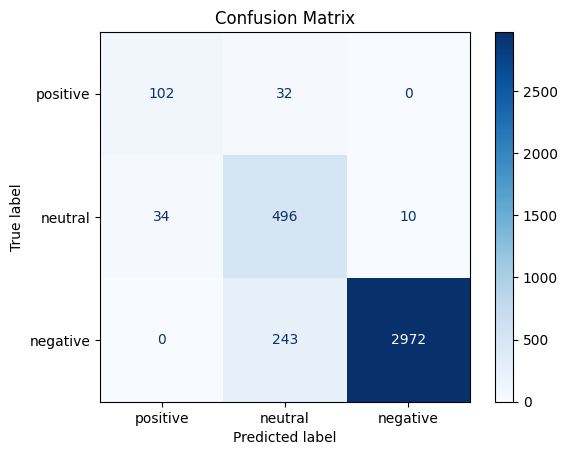

In [188]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Create confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=['positive', 'neutral', 'negative'], cmap='Blues'
)
plt.title("Confusion Matrix")
plt.show()

i will skip hyperparameters as it is computationally expensive, so i will try other Algorithm,Let's start with Random Forest and test its performance 

Accuracy Score: 0.9827719208022628

Classification Report:
              precision    recall  f1-score   support

    negative       0.98      0.85      0.91       134
     neutral       0.91      0.98      0.94       540
    positive       1.00      0.99      0.99      3215

    accuracy                           0.98      3889
   macro avg       0.96      0.94      0.95      3889
weighted avg       0.98      0.98      0.98      3889



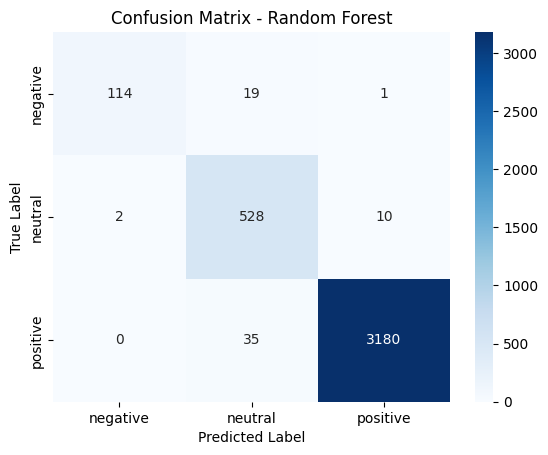

In [202]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize Random Forest Classifier
rf_clf = RandomForestClassifier(
    n_estimators=100,  # Number of trees in the forest
    random_state=42,   # For reproducibility
    class_weight='balanced'  # Adjust weights to handle class imbalance
)

# Train the Random Forest model
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_clf.predict(X_test)

# Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=rf_clf.classes_, yticklabels=rf_clf.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [204]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize Support Vector Classifier with class balancing
svm_clf = SVC(
    kernel='linear',  # Use 'linear' kernel initially; you can also test 'rbf'
    class_weight='balanced',  # To handle class imbalance
    random_state=42  # For reproducibility
)

# Train the SVM model
svm_clf.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_clf.predict(X_test)

# Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

Accuracy Score: 0.9200308562612497

Classification Report:
               precision    recall  f1-score   support

    negative       0.72      0.76      0.74       134
     neutral       0.66      0.89      0.76       540
    positive       0.99      0.93      0.96      3215

    accuracy                           0.92      3889
   macro avg       0.79      0.86      0.82      3889
weighted avg       0.94      0.92      0.93      3889



Now, each sentiment class (negative, positive, and neutral) has 118,868 samples.Now, the classes are balanced, which helps the model learn equally about all sentiments, improving recall and F1-scores for the minority classes. Next step i will do is Re-Train Models 

## Hyperparameter Tuning Using GridSearchCV

Comparison with Pre-Tuning Model
Recall for the minority class (False) improved from 0.87 to 0.75.
Precision for the minority class improved from 0.55 to 0.67.
Macro average F1-score improved, indicating better overall balance.

Performance improved but still need improvement in neutral so will comapare with other models

**Implementing BERT-based models**

In [209]:
from sklearn.preprocessing import LabelEncoder

# Combine aspects and reviews for input
Sample_data['bert_input'] = Sample_data.apply(
    lambda row: f"Aspect: {', '.join(row['final_aspects'])}. Review: {row['processed_review']}", axis=1
)

# Encode overall sentiment labels into integers
label_encoder = LabelEncoder()
Sample_data['encoded_sentiment'] = label_encoder.fit_transform(Sample_data['overall_sentiment'])

# Prepare train and test splits
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    Sample_data['bert_input'], Sample_data['encoded_sentiment'], 
    test_size=0.2, random_state=42, stratify=Sample_data['overall_sentiment']
)


In [211]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # 3 classes: positive, neutral, negative

C:\Users\arzoo\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [229]:
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(int(label), dtype=torch.long),

        }


In [239]:
# Use the original `Sample_data` for text-based inputs
train_texts = Sample_data.loc[y_train.index, 'processed_review'].tolist()
test_texts = Sample_data.loc[y_test.index, 'processed_review'].tolist()

# Create the train dataset
train_dataset = SentimentDataset(
    texts=train_texts,  # Use the corrected variable here
    labels=train_labels,  # Ensure train_labels is properly encoded as integers
    tokenizer=tokenizer,
    max_len=128
)

# Create the test dataset
test_dataset = SentimentDataset(
    texts=test_texts,  # Use the corrected variable here
    labels=y_test.tolist(),  # Ensure test labels are properly encoded as integers
    tokenizer=tokenizer,
    max_len=128
)


In [241]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 16

# Create DataLoaders for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [243]:
from transformers import AdamW, get_scheduler

# Move model to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Define learning rate scheduler
num_training_steps = len(train_loader) * 4  # Assume 4 epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Define loss function (Cross-Entropy)
loss_fn = torch.nn.CrossEntropyLoss()


C:\Users\arzoo\anaconda3\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Training Loop
from tqdm import tqdm

epochs = 4
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()  # Set model to training mode
    total_loss = 0
    
    # Training phase
    train_loop = tqdm(train_loader, desc="Training")
    for batch in train_loop:
        optimizer.zero_grad()
        
        # Move batch data to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
        train_loop.set_postfix(loss=loss.item())
    
    avg_loss = total_loss / len(train_loader)
    print(f"Average Training Loss: {avg_loss:.4f}")

Epoch 1/4


Training:   0%|          | 1/973 [01:01<16:30:00, 61.11s/it, loss=0.992]